In [10]:
! pip install seaborn

     ---------------------------------------- 0.0/160.8 kB ? eta -:--:--
     ------- ----------------------------- 30.7/160.8 kB 640.0 kB/s eta 0:00:01
     ---------------------- ---------------- 92.2/160.8 kB 1.1 MB/s eta 0:00:01
     ------------------------------------ - 153.6/160.8 kB 1.1 MB/s eta 0:00:01
     -------------------------------------- 160.8/160.8 kB 1.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/294.8 kB ? eta -:--:--
   -------------------------- ------------- 194.6/294.8 kB 5.9 MB/s eta 0:00:01
   -------------------------------------- - 286.7/294.8 kB 4.5 MB/s eta 0:00:01
   ---------------------------------------- 294.8/294.8 kB 3.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
    --------------------------------------- 0.1/7.6 MB ? eta -:--:--
    --------------------------------------- 0.1/7.6 MB ? eta -:--:--
   -- ------------------------------------- 0.6/7.6 MB 3.9 MB/s eta 0:00:02
   ---- -----

In [11]:
# системные библиотеки
import os
import time
import shutil
import pathlib
import itertools

# библиотеки для предобработки
import numpy as np
import cv2
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# библиотеки для обучения
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# игнор предупреждений
import warnings
warnings.filterwarnings("ignore")

# Создание необходимых функций

## Функция для создания датафрейма

In [3]:
# создание путей к данным с метками класса
def define_paths(dir):
    file_paths = []
    labels = []

    folds = os.listdir(dir)
    for fold in folds:
        fold_path = os.path.join(dir, fold)
        file_list = os.listdir(fold_path)

        for fold_ in file_list:
            fold_path_ = os.path.join(fold_path, fold_)
            file_list_ = os.listdir(fold_path_)

            for file_ in file_list_:
                fpath = os.path.join(fold_path_, file_)
                file_paths.append(fpath)
                labels.append(fold_)
    return file_paths, labels

# соединение пути к данным с метками класса в один dataframe
def define_df(files, classes):
    Fseries = pd.Series(files, name='filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis = 1)

# функция создания dataframe для обучающей, валидационной и тестовой выборок
def create_df(data_dir):

    files, classes = define_paths(data_dir)
    df = define_df(files, classes)

    # для обучения
    strat = df['labels']
    train_df, dummy_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=123, stratify=strat)

    # для теста
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)

    return train_df, valid_df, test_df

# Функция получения изображений при помощи dataframe

In [4]:
def create_model_data(train_df, valid_df, test_df, batch_size):
    """
    Функция получает на вход обучающий, валидационный и тестовый dataframe, и отдает их  image data generator, модель получает данные от image data generator.
    Image data generator конвертирует изображения в тензор
    """

    # определение параметров модели
    img_size = (224, 224)
    channels = 3
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length %n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe(train_df, x_col= 'filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode=color, shuffle= True, batch_size=batch_size)
    valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode=color, shuffle= True, batch_size=batch_size)
    test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode=color, shuffle= False, batch_size= test_batch_size)
    return train_gen, valid_gen, test_gen

# Функция для отображения примеров данных

In [5]:
def show_images(gen):
    """
    Функция получает data generator и показывает примеры изображений
    :param gen:
    :return:
    """

    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)

    length = len(labels)
    sample = min(length, 25)

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i+1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color= 'blue', fontsize = 12)
        plt.axis('off')
    plt.show()

In [6]:
def plot_label_count(df, plot_title):
    '''
    Функция принимает на вход dataframe и метки классов для отображения
    :param df:
    :param plot_title:
    :return:
    '''

    vcounts = df['labels'].value_counts()
    labels = vcounts.keys().tolist()
    values = vcounts.tolist()
    lcount = len(labels)

    if lcount > 55:
        print("Кол-во меток больше 55, ничего не будет выведено")
    else:
        plot_labels(lcount, labels, values, plot_title)

def plot_labels(lcount, labels, values, plot_title):
    width = lcount * 4
    width = np.min([width,  20])

    plt.figure(figsize=(width, 5))

    form = {'family' : 'serif', 'color' : 'blue', 'size' : '25'}
    sns.barplot(labels, values)
    plt.title(f'Изображений на метку в {plot_title}', fontsize = 24, color = 'blue')
    plt.xticks(rotation = 90, fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.xlabel('CLASS', fontdict = form)
    yaxis_label = 'IMAGE COUNT'
    plt.ylabel(yaxis_label, fontdict = form)

    rotation = 'vertical' if lcount >= 8 else 'horizontal'
    for i in range(lcount):
        plt.text(i, values[i] / 2, str(values[i]), fontsize = 12, rotation = rotation, color = 'yellow', ha = 'center')

    plt.show()

# Callbacks - вспомогательные функции для помощи в оптимизации модели при обучении

In [7]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer

                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')

# Функция для отображения истории обучения

In [8]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [9]:
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion Matrix', cmap = plt.cm.Blues):
    '''
    Функция отображает матрицу ошибок
    '''

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print('Нормализованная матрица ошибок')
    else:
        print('Матрица ошибок без нормализации')
    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

# Структура модели

## Читаем данные

In [10]:
data_dir = 'C:/Users/nero1/PycharmProjects/pythonProject7/training_data'

try:
    train_df, valid_df, test_df =create_df(data_dir)

    batch_size = 50
    train_gen, valid_gen, test_gen = create_model_data(train_df, valid_df, test_df, batch_size)
except:
    print('Invalid Input')


Found 7462 validated image filenames belonging to 2 classes.
Found 1599 validated image filenames belonging to 2 classes.
Found 1600 validated image filenames belonging to 2 classes.


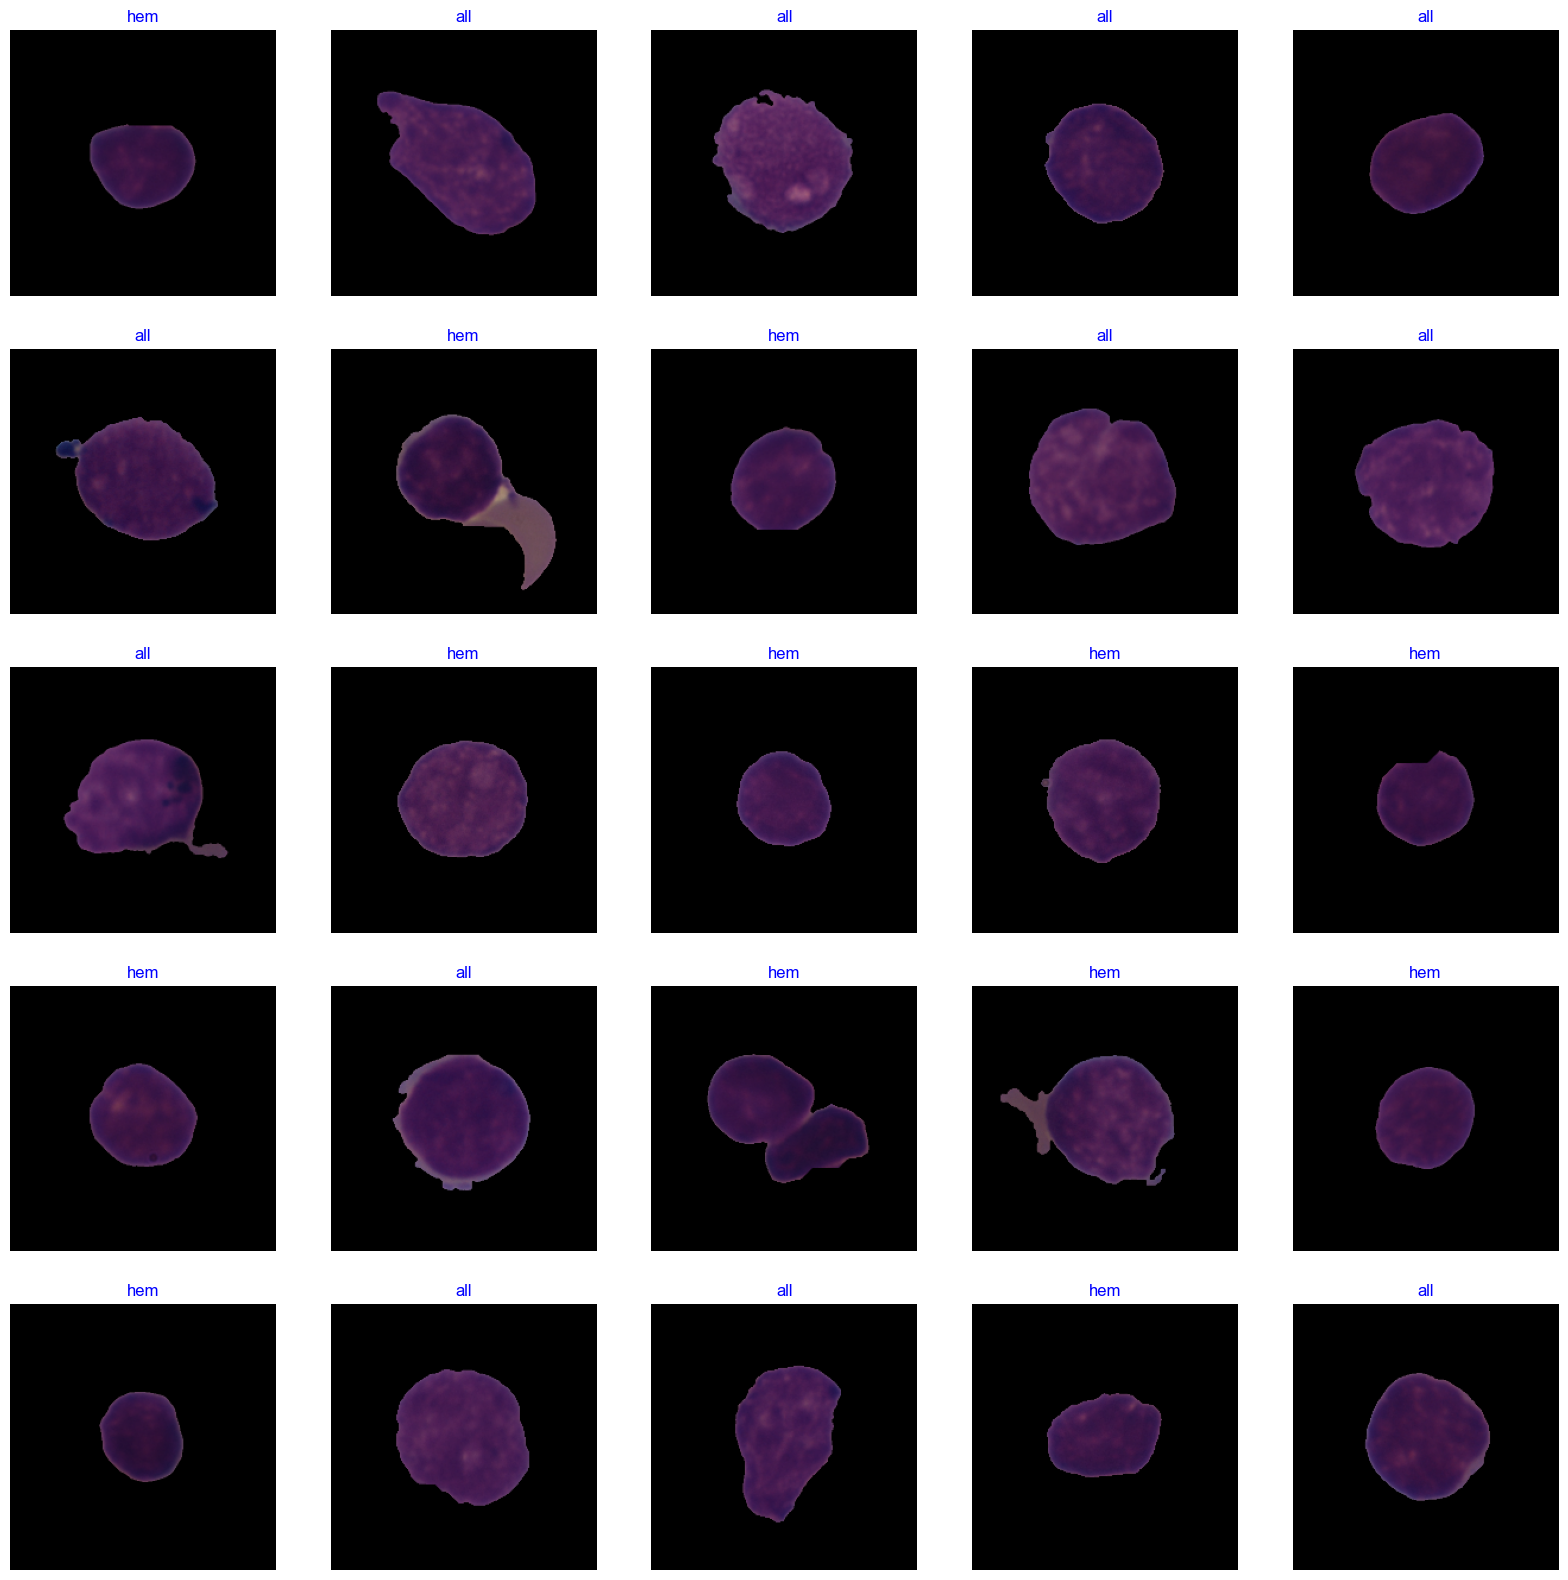

In [11]:
show_images(train_gen)

In [12]:
img_size = (224, 224)
channels= 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights='imagenet', input_shape= img_shape, pooling='max')
model = Sequential([
    base_model,
    BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l = 0.016), activity_regularizer = regularizers.l1(0.006), bias_regularizer = regularizers.l1(0.006),
          activation = 'relu'),
    Dropout(rate = 0.45, seed = 123),
    Dense(class_count, activation = 'softmax')
])

model.compile(Adamax(learning_rate = 0.001), loss= 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 11183665 (42.66 MB)
Trainable params: 1109

In [13]:
for layer in base_model.layers:
    print(layer.name)

input_1
rescaling
normalization
rescaling_1
stem_conv_pad
stem_conv
stem_bn
stem_activation
block1a_dwconv
block1a_bn
block1a_activation
block1a_se_squeeze
block1a_se_reshape
block1a_se_reduce
block1a_se_expand
block1a_se_excite
block1a_project_conv
block1a_project_bn
block1b_dwconv
block1b_bn
block1b_activation
block1b_se_squeeze
block1b_se_reshape
block1b_se_reduce
block1b_se_expand
block1b_se_excite
block1b_project_conv
block1b_project_bn
block1b_drop
block1b_add
block2a_expand_conv
block2a_expand_bn
block2a_expand_activation
block2a_dwconv_pad
block2a_dwconv
block2a_bn
block2a_activation
block2a_se_squeeze
block2a_se_reshape
block2a_se_reduce
block2a_se_expand
block2a_se_excite
block2a_project_conv
block2a_project_bn
block2b_expand_conv
block2b_expand_bn
block2b_expand_activation
block2b_dwconv
block2b_bn
block2b_activation
block2b_se_squeeze
block2b_se_reshape
block2b_se_reduce
block2b_se_expand
block2b_se_excite
block2b_project_conv
block2b_project_bn
block2b_drop
block2b_add
blo

In [ ]:
batch_size = 40
epochs =10
patience = 1
stop_patience = 3
threshold = 0.9
factor = 0.5
ask_epoch = 5
batches = int(np.ceil(len(train_gen.labels) / batch_size))

callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

In [ ]:
history = model.fit(x = train_gen, epochs = epochs, verbose = 0, callbacks = callbacks, validation_data = valid_gen, validation_steps = None, shuffle = False)

input_4
rescaling_5
normalization_3
rescaling_6
stem_conv_pad
stem_conv
stem_bn
stem_activation
block1a_dwconv
block1a_bn
block1a_activation
block1a_se_squeeze
block1a_se_reshape
block1a_se_reduce
block1a_se_expand
block1a_se_excite
block1a_project_conv
block1a_project_bn
block1b_dwconv
block1b_bn
block1b_activation
block1b_se_squeeze
block1b_se_reshape
block1b_se_reduce
block1b_se_expand
block1b_se_excite
block1b_project_conv
block1b_project_bn
block1b_drop
block1b_add
block2a_expand_conv
block2a_expand_bn
block2a_expand_activation
block2a_dwconv_pad
block2a_dwconv
block2a_bn
block2a_activation
block2a_se_squeeze
block2a_se_reshape
block2a_se_reduce
block2a_se_expand
block2a_se_excite
block2a_project_conv
block2a_project_bn
block2b_expand_conv
block2b_expand_bn
block2b_expand_activation
block2b_dwconv
block2b_bn
block2b_activation
block2b_se_squeeze
block2b_se_reshape
block2b_se_reduce
block2b_se_expand
block2b_se_excite
block2b_project_conv
block2b_project_bn
block2b_drop
block2b_add

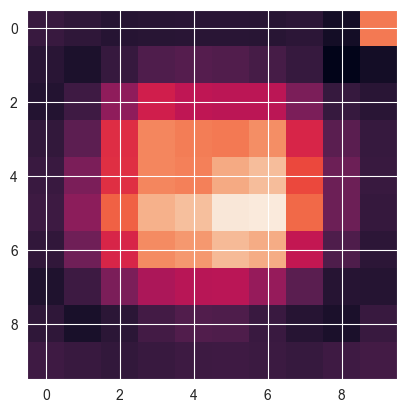

In [16]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
import numpy as np


model = EfficientNetB3(weights='imagenet')

# Вывод имен всех слоев внутри efficientnetb3
for layer in model.layers:
    print(layer.name)

# Получение последнего сверточного слоя внутри efficientnetb3
last_conv_layer = model.get_layer('top_conv')

# Создание модели с усеченной последовательностью слоев
grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])

# Пример загрузки и предобработки изображения
img_path = "C:/Users/nero1/PycharmProjects/pythonProject7/training_data/fold_0/hem/UID_H6_1_1_hem.bmp"
img = image.load_img(img_path, target_size=(300, 300))  # Пример, входное изображение должно иметь размерность, соответствующую EfficientNetB3
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Вычисление Grad-CAM
with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(img_array)
    class_idx = np.argmax(preds[0])
    loss = preds[:, class_idx]

grads = tape.gradient(loss, last_conv_layer_output)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()

# Умножение каждого канала на соответствующий весовой коэффициент
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

# Создание тепловой карты Grad-CAM
heatmap = np.mean(last_conv_layer_output, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Визуализация тепловой карты на изображении
import matplotlib.pyplot as plt
plt.imshow(heatmap)
plt.show()

In [ ]:
plot_training(history)

In [ ]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

In [12]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

NameError: name 'model' is not defined

In [13]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

NameError: name 'y_pred' is not defined

In [ ]:
model_name = model.input_names[0][:-6]
subject = input('Enter Project Subject')
acc = test_score[1] * 100
save_path = ''

# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

In [25]:
model1 = tf.keras.models.load_model("C:/Users/nero1/PycharmProjects/pythonProject7/model.h5")

In [26]:
model1.evaluate(train_gen, steps= test_steps, verbose= 1)

20/20 [==============================] - 47s 2s/step - loss: 0.0969 - accuracy: 0.9990


[0.09688211232423782, 0.9990000128746033]

In [27]:
classes=list(train_gen.class_indices.keys())

In [30]:
img=plt.imread("C:/Users/nero1/PycharmProjects/pythonProject7/training_data/fold_2/hem/UID_H2_41_1_hem.bmp")
img=cv2.resize(img, img_size)
img=np.expand_dims(img, axis=0)
pred=model.predict(img)
index=np.argmax(pred[0])
klass=classes[index]
probability=pred[0][index]*100

1/1 [==============================] - 0s 63ms/step


In [31]:
print(f'the image is predicted as being {klass} with a probability of {probability:6.2f} %')

the image is predicted as being hem with a probability of  97.32 %


In [32]:
print(classes)

['all', 'hem']
